# 📘 Generalized 3-Factor Hull–White Model – Coupled Dynamics

The **generalized Hull–White model** extends the traditional short-rate interest rate model by introducing coupling between multiple mean-reverting factors. In this formulation, the short rate is primarily driven by a main factor that is influenced not only by its own mean-reversion but also by auxiliary factors. This structure allows for more realistic modeling of the term structure and richer dynamics in interest rate evolution.

---

## 🧠 Overview

Unlike the additive Ornstein-Uhlenbeck version where each factor evolves independently, this generalized model introduces **inter-factor dependencies**. The main factor $ x(t) $ reverts to a long-term mean $ \mu_1 $, but its drift is also affected by the current values of the auxiliary factors $ y(t) $ and $ z(t) $, scaled by coefficients $ \beta_2 $ and $ \beta_3 $. This coupling enables the model to capture more complex behaviors such as shifts and twists in the yield curve.

---

## 🧮 Model Structure

The short rate is defined as:

$
r(t) = x(t)
$

The factors evolve according to the following stochastic differential equations (SDEs):

$
\begin{aligned}
dx(t) &= a_1 \left( \mu_1 - x(t) + \beta_2 y(t) + \beta_3 z(t) \right) dt + \sigma_1 dW_1(t) \\\\
dy(t) &= -a_2 y(t) dt + \sigma_2 dW_2(t) \\\\
dz(t) &= -a_3 z(t) dt + \sigma_3 dW_3(t)
\end{aligned}
$

Where:
- $ a_i $: Mean-reversion speed of factor $ i $
- $ \mu_1 $: Long-term mean level for the main factor $ x(t) $
- $ \beta_2, \beta_3 $: Coupling coefficients for scaling coefficients that control how much $y(t)$ and $z(t)$ influence $x(t)$
- $ \sigma_i $: Volatility of factor $ i $
- $ W_i(t) $: Brownian motions (possibly correlated)

---

## 🔗 Correlation Structure

The Brownian motions $ W_1, W_2, W_3 $ are correlated. The correlation matrix is:

$
\begin{bmatrix}
1 & \rho_{12} & \rho_{13} \\\\
\rho_{12} & 1 & \rho_{23} \\\\
\rho_{13} & \rho_{23} & 1
\end{bmatrix}
$

To simulate correlated random variables, **Cholesky decomposition** is applied to this matrix.

---

## 🎲 Monte Carlo Simulation

The model uses **Monte Carlo simulation** to generate multiple paths of the short rate:

1. **Initialize** the factors $ x_0, y_0, z_0 $
2. **For each time step**:
   - Generate 3 correlated normal random variables
   - Update each factor using its SDE
   - Compute the short rate $ r(t) = x(t) $
3. **Repeat** for multiple paths

---

## 📊 Output

- The simulation returns all paths of the short rate.
- The `mean_path` function computes the **average final short rate** across all simulated paths.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

class HullWhite3FactorCoupled:
    def __init__(self, a1, a2, a3, mu1, beta2, beta3, sigma1, sigma2, sigma3):
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.mu1 = mu1
        self.beta2 = beta2
        self.beta3 = beta3
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.sigma3 = sigma3

    def cholesky_correlated_normals(self, rho12, rho13, rho23):
        corr_matrix = np.array([
            [1.0, rho12, rho13],
            [rho12, 1.0, rho23],
            [rho13, rho23, 1.0]
        ])
        L = np.linalg.cholesky(corr_matrix)
        z_uncorr = np.random.normal(0, 1, 3)
        z_corr = np.dot(L, z_uncorr)
        return z_corr

    def MC_model(self, num_of_paths, iterations, x0, y0, z0, rho12, rho13, rho23):
        dt = 0.01
        all_paths = []
        np.random.seed(42)

        for i in range(num_of_paths):
            x = [x0]
            y = [y0]
            z = [z0]
            r = [x0]

            for j in range(iterations):
                z_corr = self.cholesky_correlated_normals(rho12, rho13, rho23)

                dy = -self.a2 * (y[-1]) * dt + self.sigma2 * np.sqrt(dt) * z_corr[1]
                dz = -self.a3 * (z[-1]) * dt + self.sigma3 * np.sqrt(dt) * z_corr[2]

                y_new = y[-1] + dy
                z_new = z[-1] + dz

                dx = self.a1 * (self.mu1 - x[-1] + self.beta2 * y_new + self.beta3 * z_new) * dt + self.sigma1 * np.sqrt(dt) * z_corr[0]
                x_new = x[-1] + dx

                x.append(x_new)
                y.append(y_new)
                z.append(z_new)
                r.append(x_new)

            all_paths.append(r)

        return all_paths

    def mean_path(self, all_paths):
        final_rates = [path[-1] for path in all_paths]
        return np.mean(final_rates)



Mean of final interest rates across all paths: 0.094833


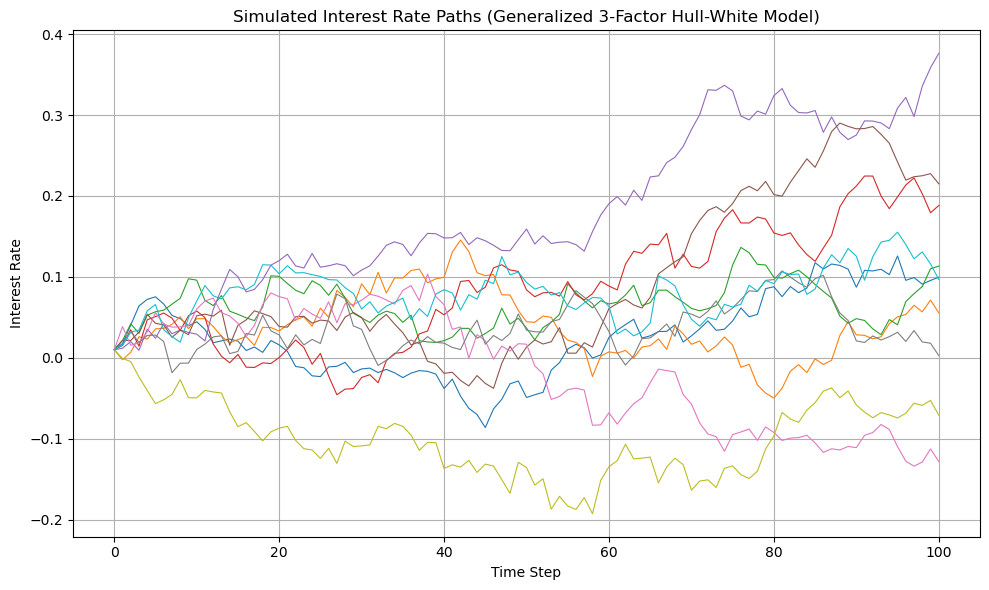

In [9]:
# Example usage
# model = HullWhite3FactorCoupled(
#     a1=0.3, a2=0.7, a3=1.1,
#     mu1=0.002, 
#     beta2=0.8, beta3=0.8,
#     sigma1=0.15, sigma2=0.25, sigma3=0.35
# )

model = HullWhite3FactorCoupled(
    a1=0.3, a2=0.7, a3=1.1,
    mu1=0.002, 
    beta2=0.8, beta3=0.8,
    sigma1=0.15, sigma2=0.25, sigma3=0.35
)

simulated_paths = model.MC_model(
    num_of_paths=10,
    iterations=100,
    x0=0.01, y0=0.01, z0=0.01,
    rho12=0.2, rho13=0.1, rho23=0.3
)

mean_final_rate = model.mean_path(simulated_paths)
print(f"Mean of final interest rates across all paths: {mean_final_rate:.6f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.xlabel('Time Step')
plt.ylabel('Interest Rate')
plt.title('Simulated Interest Rate Paths (Generalized 3-Factor Hull-White Model)')

for path in simulated_paths:
    plt.plot(path, linewidth=0.8)

plt.grid(True)
plt.tight_layout()
plt.show()
